Importing the datasets from Google Drive

In [2]:
!pip install transformers datasets scikit-learn -q
!pip install shap

import pandas as pd
from datasets import Dataset, DatasetDict
from google.colab import drive

#mount google drive to get the datasets
drive.mount('/content/drive')

print('Loading datasets from google drive...')
drive_path='/content/drive/My Drive/Colab Notebooks/'

datset1='Dataset1.csv'
dataset2='Dataset2.csv'
dataset3='Dataset3.csv'

df_D1=pd.read_csv(drive_path+datset1)
df_D2=pd.read_csv(drive_path+dataset2)
df_D3=pd.read_csv(drive_path+dataset3)

print('Data loading and processing complete.')

Mounted at /content/drive
Loading datasets from google drive...
Data loading and processing complete.


Setting up the distilBERT model for Dataset1. Then testing the model with Dataset2 and 3.


--- Data Split ---
D1_train: Dataset({
    features: ['email_text', 'label'],
    num_rows: 3200
})
D1_test: Dataset({
    features: ['email_text', 'label'],
    num_rows: 800
})
D2_train: Dataset({
    features: ['email_text', 'label'],
    num_rows: 8000
})
D2_test: Dataset({
    features: ['email_text', 'label'],
    num_rows: 2000
})
D3_train: Dataset({
    features: ['email_text', 'label'],
    num_rows: 30531
})
D3_test: Dataset({
    features: ['email_text', 'label'],
    num_rows: 7633
})
Loading tokenizer and model for distilbert-base-uncased...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing datasets...


Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30531 [00:00<?, ? examples/s]

Map:   0%|          | 0/7633 [00:00<?, ? examples/s]

Device set to use cuda:0


Creating a balanced sample of 20 emails for SHAP
Setting up trainer...

Starting training on Dataset1... 


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: racanal2 (racanal2-university-of-houston) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.061500,0.075522,0.977500,0.965602,0.989924,0.977612
2,0.024900,0.025990,0.992500,1.000000,0.984887,0.992386
3,0.015400,0.022419,0.992500,0.992443,0.992443,0.992443



 Training finished. Evaluating on Dataset1...


Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F1: 0.99

Testing Dataset2 on Dataset1 model...
Accuracy: 0.94
Precision: 1.00
Recall: 0.91
F1: 0.95

Testing Dataset3 on Dataset1 model...
Accuracy: 0.72
Precision: 0.94
Recall: 0.52
F1: 0.67


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
PartitionExplainer explainer:  60%|██████    | 12/20 [00:31<00:21,  2.64s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (587 > 512). Running this sequence through the model will result in indexing errors
PartitionExplainer explainer: 21it [00:54,  3.06s/it]

Done!


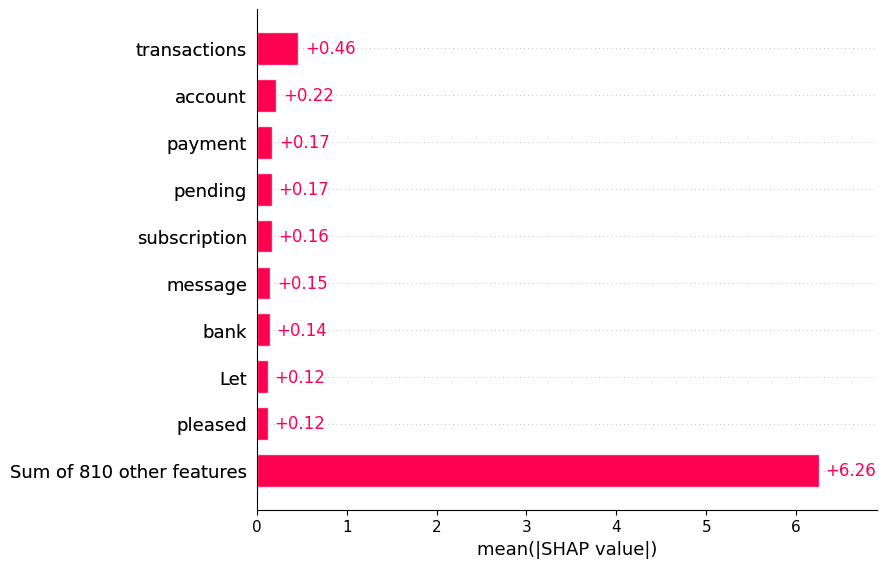


Saving fine-tuned model to: /content/drive/My Drive/Colab Notebooks/D1_finetuned_model
Model saved successfully


In [4]:
import torch
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    TextClassificationPipeline
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datasets import Dataset
import shap

#converting to Hugging Face dataset and splitting
dataset1=Dataset.from_pandas(df_D1)
dataset2=Dataset.from_pandas(df_D2)
dataset3=Dataset.from_pandas(df_D3)

#Splitting the datasets into train and test sets
D1_split=dataset1.train_test_split(test_size=0.2, seed=42)
D2_split=dataset2.train_test_split(test_size=0.2, seed=42)
D3_split=dataset3.train_test_split(test_size=0.2, seed=42)

D1_train=D1_split['train']
D1_test=D1_split['test']

D2_train=D2_split['train']
D2_test=D2_split['test']

D3_train=D3_split['train']
D3_test=D3_split['test']

print('\n--- Data Split ---')
print(f'D1_train: {D1_train}')
print(f'D1_test: {D1_test}')
print(f'D2_train: {D2_train}')
print(f'D2_test: {D2_test}')
print(f'D3_train: {D3_train}')
print(f'D3_test: {D3_test}')

#Model and tokenizer Setup

model_name='distilbert-base-uncased'
print(f'Loading tokenizer and model for {model_name}...')
tokenizer=AutoTokenizer.from_pretrained(model_name)
model=AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label={0: 'LEGITIMATE', 1: 'PHISHING'},
    label2id={'LEGITIMATE': 0, 'PHISHING': 1}
)

#Tokenizing the datasets
def tokenize_function(examples):
    return tokenizer(examples['email_text'], padding='max_length', truncation=True)
print('Tokenizing datasets...')
tokenized_D1_train=D1_train.map(tokenize_function, batched=True)
tokenized_D1_test=D1_test.map(tokenize_function, batched=True)
tokenized_D2_train=D2_train.map(tokenize_function, batched=True)
tokenized_D2_test=D2_test.map(tokenize_function, batched=True)
tokenized_D3_train=D3_train.map(tokenize_function, batched=True)
tokenized_D3_test=D3_test.map(tokenize_function, batched=True)

#Defining metrics
def compute_metrics(p):
    preds=p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds=np.argmax(preds, axis=-1)

    accuracy=accuracy_score(p.label_ids, preds)
    precision=precision_score(p.label_ids, preds, average='binary')
    recall=recall_score(p.label_ids, preds, average='binary')
    f1=f1_score(p.label_ids, preds, average='binary')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

#Creating the SHAP pipeline
pipe =TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    device=0,
    truncation=True,
    max_length=512
)

print('Creating a balanced sample of 20 emails for SHAP')
phishing_df=df_D1[df_D1['label']==1]
legitimate_df=df_D1[df_D1['label']==0]
phishing_samples=phishing_df.sample(10, replace=True)
legitimate_samples=legitimate_df.sample(10, replace=True)
subset_df=pd.concat([phishing_samples, legitimate_samples]).sample(frac=1)
subset_text1=subset_df['email_text'].tolist()

#Defining training arguments
print('Setting up trainer...')

training_args=TrainingArguments(
    output_dir='./D1_results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./D1_logs',
    logging_steps=100,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True
)

#Creating and running trainer
trainer=Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_D1_train,
    eval_dataset=tokenized_D1_test,
    compute_metrics=compute_metrics
)

print('\nStarting training on Dataset1... ')
trainer.train()

#final eval
print('\n Training finished. Evaluating on Dataset1...')
eval_results=trainer.evaluate()

print(f"Accuracy: {eval_results['eval_accuracy']:.2f}")
print(f"Precision: {eval_results['eval_precision']:.2f}")
print(f"Recall: {eval_results['eval_recall']:.2f}")
print(f"F1: {eval_results['eval_f1']:.2f}")

print('\nTesting Dataset2 on Dataset1 model...')
eval_results=trainer.evaluate(eval_dataset=tokenized_D2_test)

print(f"Accuracy: {eval_results['eval_accuracy']:.2f}")
print(f"Precision: {eval_results['eval_precision']:.2f}")
print(f"Recall: {eval_results['eval_recall']:.2f}")
print(f"F1: {eval_results['eval_f1']:.2f}")

print('\nTesting Dataset3 on Dataset1 model...')
eval_results=trainer.evaluate(eval_dataset=tokenized_D3_test)

print(f"Accuracy: {eval_results['eval_accuracy']:.2f}")
print(f"Precision: {eval_results['eval_precision']:.2f}")
print(f"Recall: {eval_results['eval_recall']:.2f}")
print(f"F1: {eval_results['eval_f1']:.2f}")

#init SHAP
explainer=shap.Explainer(pipe, output_names=['LEGITIMATE', 'PHISHING'])
shap_values=explainer(subset_text1)
print('Done!')
shap.initjs()
shap.plots.bar(shap_values[:,:,'PHISHING'])

#saving fine-tuned model
model_save_path = drive_path + "D1_finetuned_model"
print(f"\nSaving fine-tuned model to: {model_save_path}")
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)
print("Model saved successfully")



Setting up model for Dataset2. Then it will be tested with Dataset1 and 3

Setting up trainer for Dataset2...

Starting training on Dataset2...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,0.000003,1.000000,1.000000,1.000000,1.000000
2,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
3,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000



--- Training Finished. Final eval on Dataset2 test set ---


Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1: 1.00

Testing Dataset1 on Dataset2 model...
Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F1: 0.99

Testing Dataset3 on Dataset2 model...
Accuracy: 0.74
Precision: 0.91
Recall: 0.58
F1: 0.71

Starting SHAP Explainer... 


PartitionExplainer explainer: 51it [02:09,  2.76s/it]


Done!

--- SHAP Plot ---


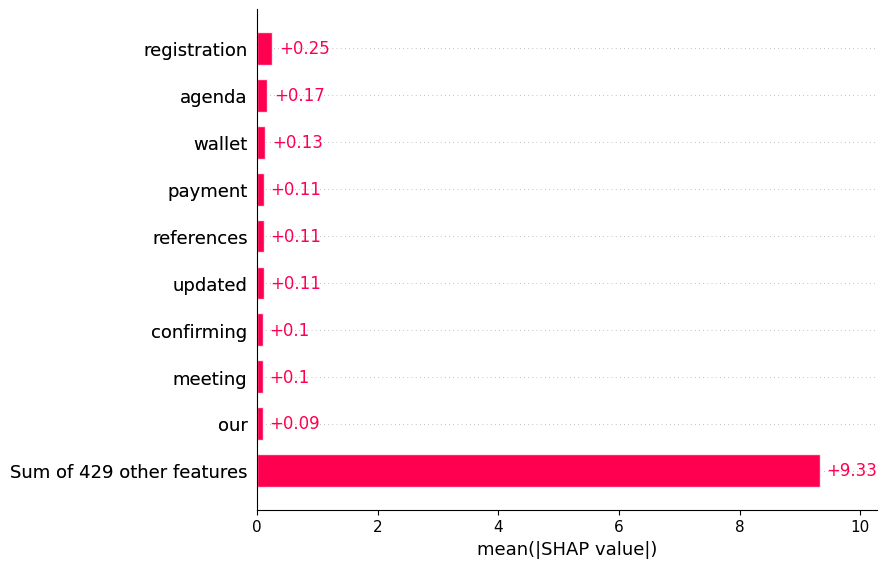


Saving fine-tuned model to: /content/drive/My Drive/Colab Notebooks/D2_finetuned_model
Model saved successfully


In [5]:
#Setting up Trainer for Dataset2
print('Setting up trainer for Dataset2...')
training_args=TrainingArguments(
    output_dir='./D2_results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./D2_logs',
    logging_steps=100,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True
)

#Creating and running trainer
trainer=Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_D2_train,
    eval_dataset=tokenized_D2_test,
    compute_metrics=compute_metrics
)

print('\nStarting training on Dataset2...')
trainer.train()

print('\n--- Training Finished. Final eval on Dataset2 test set ---')
eval_results=trainer.evaluate()

print(f"Accuracy: {eval_results['eval_accuracy']:.2f}")
print(f"Precision: {eval_results['eval_precision']:.2f}")
print(f"Recall: {eval_results['eval_recall']:.2f}")
print(f"F1: {eval_results['eval_f1']:.2f}")

#getting 50 samples from Dataset2
phishing_df=df_D2[df_D2['label']==1]
legitimate_df=df_D2[df_D2['label']==0]

phishing_samples=phishing_df.sample(25, replace=True)
legitimate_samples=legitimate_df.sample(25, replace=True)
subset_df=pd.concat([phishing_samples, legitimate_samples]).sample(frac=1)
subset_text2=subset_df['email_text'].tolist()

print('\nTesting Dataset1 on Dataset2 model...')
eval_results=trainer.evaluate(eval_dataset=tokenized_D1_test)
print(f"Accuracy: {eval_results['eval_accuracy']:.2f}")
print(f"Precision: {eval_results['eval_precision']:.2f}")
print(f"Recall: {eval_results['eval_recall']:.2f}")
print(f"F1: {eval_results['eval_f1']:.2f}")

print('\nTesting Dataset3 on Dataset2 model...')
eval_results=trainer.evaluate(eval_dataset=tokenized_D3_test)
print(f"Accuracy: {eval_results['eval_accuracy']:.2f}")
print(f"Precision: {eval_results['eval_precision']:.2f}")
print(f"Recall: {eval_results['eval_recall']:.2f}")
print(f"F1: {eval_results['eval_f1']:.2f}")

print('\nStarting SHAP Explainer... ')
explainer=shap.Explainer(pipe, output_names=['LEGITIMATE', 'PHISHING'])
shap_values=explainer(subset_text2)
print('Done!')

print('\n--- SHAP Plot ---')
shap.plots.bar(shap_values[:,:,'PHISHING'])

model_save_path = drive_path + "D2_finetuned_model"
print(f"\nSaving fine-tuned model to: {model_save_path}")
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)
print('Model saved successfully')

Setting up model for Dataset 3 and testing it with Dataset1 and 2.

Setting up Dataset3 trainer...

Starting training on Dataset3...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.020200,0.017338,0.996725,0.995922,0.998077,0.996998
2,0.012000,0.015966,0.996856,0.995686,0.998558,0.997120
3,0.000000,0.016537,0.997642,0.997837,0.997837,0.997837



--- Training finished. Final eval on Dataset3 test set ---


Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1: 1.00

Testing Dataset1 on Dataset3 model...
Accuracy: 0.89
Precision: 1.00
Recall: 0.78
F1: 0.88

Testing Dataset2 on Dataset3 model...
Accuracy: 0.54
Precision: 1.00
Recall: 0.23
F1: 0.38

Starting SHAP Explainer... 


PartitionExplainer explainer:  11%|█         | 11/100 [00:30<04:57,  3.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 20/100 [01:08<05:22,  4.03s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  21%|██        | 21/100 [01:14<06:18,  4.79s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 38/100 [02:24<02:18,  2.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 62/100 [03:36<01:45,  2.77s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 67/100 [04:02<02:04,  3.77s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 73/100 [04:28<01:36,  3.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 86/100 [05:09<00:40,  2.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 101it [05:56,  3.67s/it]



Done!

--- SHAP Plot ---


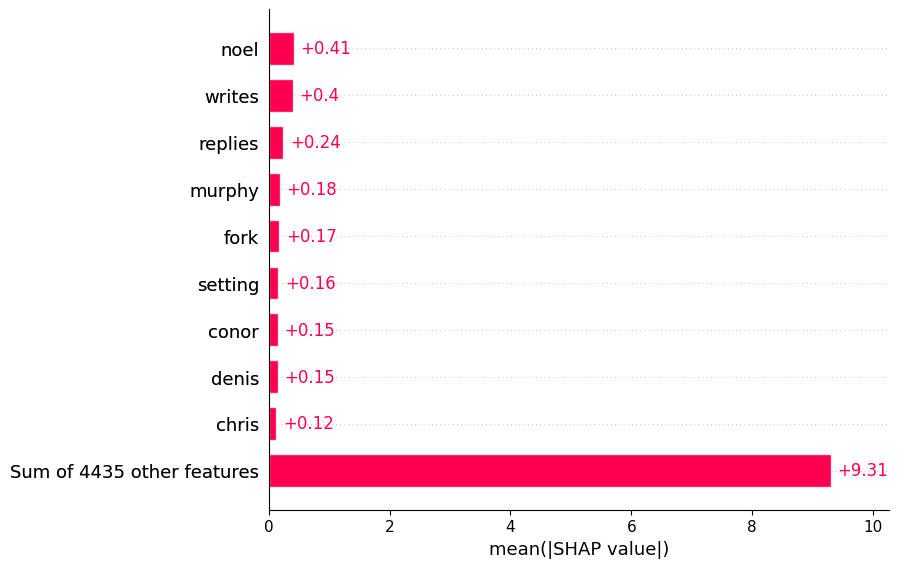


Saving fine-tuned model to: /content/drive/My Drive/Colab Notebooks/D3_finetuned_model
Model saved successfully


In [6]:
#Setting up Dataset 3 model
print('Setting up Dataset3 trainer...')

training_args=TrainingArguments(
    output_dir='./D3_results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./D3_logs',
    logging_steps=100,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True
)

#creating and running trainer
trainer=Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_D3_train,
    eval_dataset=tokenized_D3_test,
    compute_metrics=compute_metrics
)

print('\nStarting training on Dataset3...')
trainer.train()

print('\n--- Training finished. Final eval on Dataset3 test set ---')
eval_results=trainer.evaluate()

print(f"Accuracy: {eval_results['eval_accuracy']:.2f}")
print(f"Precision: {eval_results['eval_precision']:.2f}")
print(f"Recall: {eval_results['eval_recall']:.2f}")
print(f"F1: {eval_results['eval_f1']:.2f}")

#getting 50 samples from Dataset3
phishing_df=df_D3[df_D3['label']==1]
legitimate_df=df_D3[df_D3['label']==0]

phishing_samples=phishing_df.sample(50, replace=True)
legitimate_samples=legitimate_df.sample(50, replace=True)
subset_df=pd.concat([phishing_samples, legitimate_samples]).sample(frac=1)
subset_text3=subset_df['email_text'].tolist()

print('\nTesting Dataset1 on Dataset3 model...')
eval_results=trainer.evaluate(eval_dataset=tokenized_D1_test)
print(f"Accuracy: {eval_results['eval_accuracy']:.2f}")
print(f"Precision: {eval_results['eval_precision']:.2f}")
print(f"Recall: {eval_results['eval_recall']:.2f}")
print(f"F1: {eval_results['eval_f1']:.2f}")

print('\nTesting Dataset2 on Dataset3 model...')
eval_results=trainer.evaluate(eval_dataset=tokenized_D2_test)
print(f"Accuracy: {eval_results['eval_accuracy']:.2f}")
print(f"Precision: {eval_results['eval_precision']:.2f}")
print(f"Recall: {eval_results['eval_recall']:.2f}")
print(f"F1: {eval_results['eval_f1']:.2f}")

print('\nStarting SHAP Explainer... ')
explainer=shap.Explainer(pipe, output_names=['LEGITIMATE', 'PHISHING'])
shap_values=explainer(subset_text3)
print('\nDone!')

print('\n--- SHAP Plot ---')
shap.plots.bar(shap_values[:,:,'PHISHING'])

model_save_path = drive_path + "D3_finetuned_model"
print(f"\nSaving fine-tuned model to: {model_save_path}")
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)
print('Model saved successfully')


Running Dataset models 1,2, and 3 with different datasets and evaluating them with SHAP

Device set to use cuda:0



--- Starting SHAP Analysis ---
Model Path: /content/drive/My Drive/Colab Notebooks/D1_finetuned_model
Loading Model... 


/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Sampling 50 balanced emails from target dataset...
Running SHAP analysis...


PartitionExplainer explainer: 51it [02:08,  2.73s/it]



--- Global Feature Importance ---


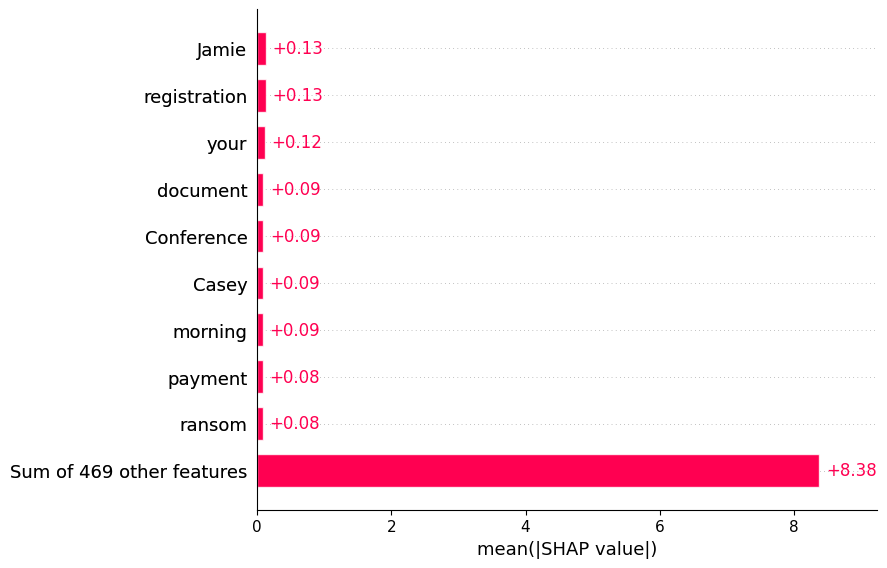

Device set to use cuda:0



--- Starting SHAP Analysis ---
Model Path: /content/drive/My Drive/Colab Notebooks/D1_finetuned_model
Loading Model... 


/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (962 > 512). Running this sequence through the model will result in indexing errors


Sampling 50 balanced emails from target dataset...
Running SHAP analysis...


PartitionExplainer explainer:  46%|████▌     | 23/50 [00:59<01:08,  2.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 25/50 [01:09<01:31,  3.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 40/50 [02:00<00:27,  2.76s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 51it [02:38,  3.37s/it]



--- Global Feature Importance ---


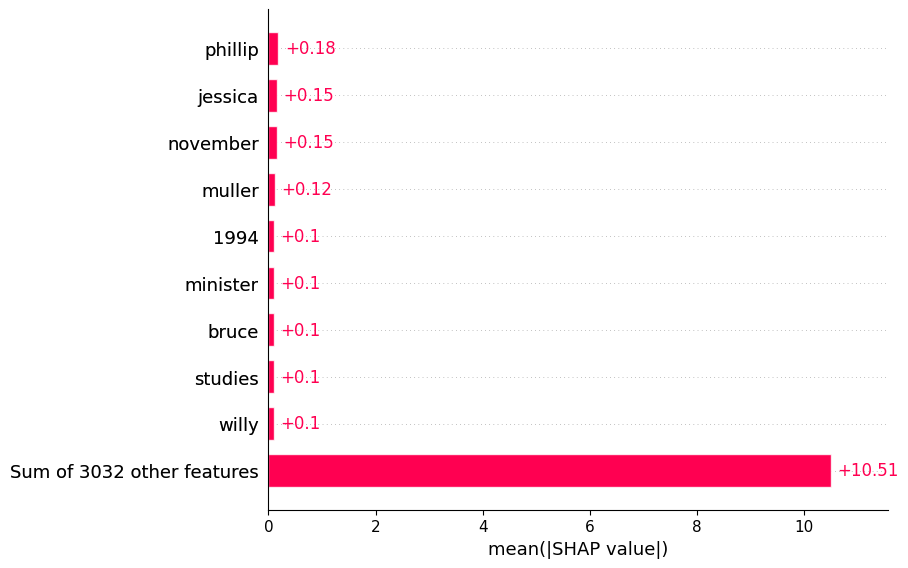

Device set to use cuda:0



--- Starting SHAP Analysis ---
Model Path: /content/drive/My Drive/Colab Notebooks/D2_finetuned_model
Loading Model... 


/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Sampling 50 balanced emails from target dataset...
Running SHAP analysis...


PartitionExplainer explainer:  26%|██▌       | 13/50 [00:32<01:44,  2.84s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (1789 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 32/50 [01:18<00:37,  2.08s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 51it [03:14,  4.13s/it]



--- Global Feature Importance ---


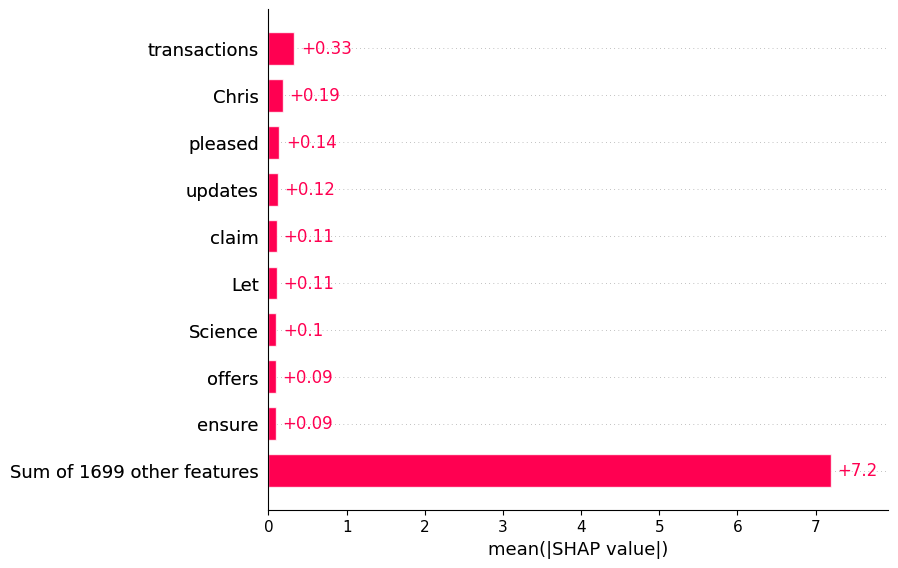

Device set to use cuda:0



--- Starting SHAP Analysis ---
Model Path: /content/drive/My Drive/Colab Notebooks/D2_finetuned_model
Loading Model... 


/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (780 > 512). Running this sequence through the model will result in indexing errors


Sampling 50 balanced emails from target dataset...
Running SHAP analysis...


PartitionExplainer explainer:   6%|▌         | 3/50 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 7/50 [00:22<02:07,  2.96s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 18/50 [01:15<01:57,  3.67s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 31/50 [01:56<00:54,  2.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▌   | 33/50 [02:05<00:59,  3.51s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 37/50 [02:19<00:41,  3.20s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 39/50 [02:34<00:56,  5.14s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 51it [03:35,  4.48s/it]



--- Global Feature Importance ---


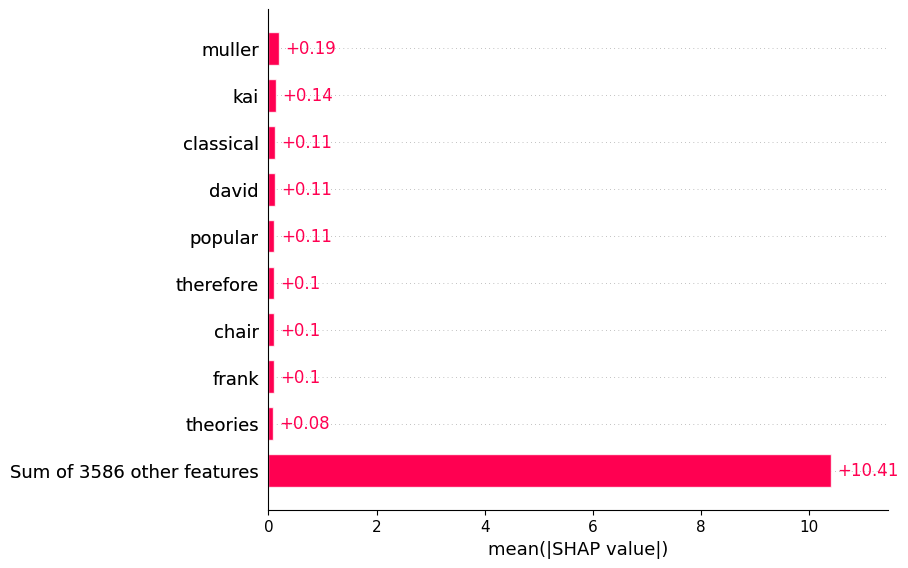

Device set to use cuda:0



--- Starting SHAP Analysis ---
Model Path: /content/drive/My Drive/Colab Notebooks/D3_finetuned_model
Loading Model... 


/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (725 > 512). Running this sequence through the model will result in indexing errors


Sampling 50 balanced emails from target dataset...
Running SHAP analysis...


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 7/50 [00:21<01:19,  1.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 14/50 [00:48<01:38,  2.74s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 51it [02:36,  3.25s/it]



--- Global Feature Importance ---


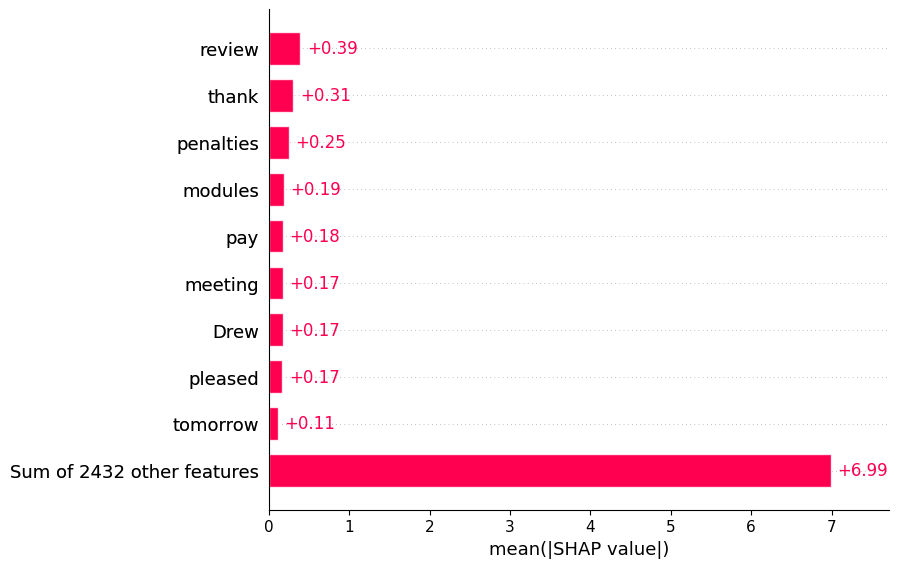

Device set to use cuda:0



--- Starting SHAP Analysis ---
Model Path: /content/drive/My Drive/Colab Notebooks/D3_finetuned_model
Loading Model... 


/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Sampling 50 balanced emails from target dataset...
Running SHAP analysis...


PartitionExplainer explainer: 51it [02:08,  2.73s/it]



--- Global Feature Importance ---


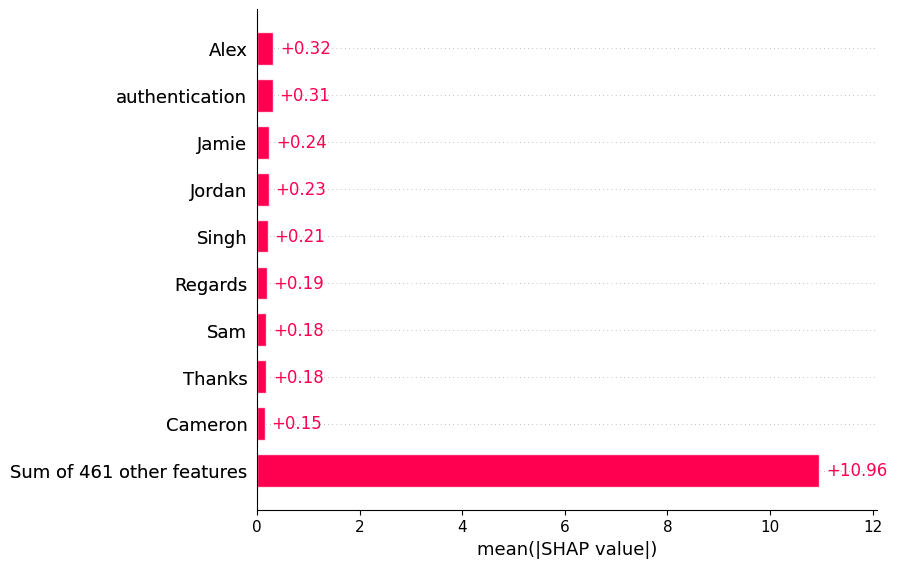

In [7]:
def run_cross_dataset_SHAP_analysis(model_path, target_dataset):

  print('\n--- Starting SHAP Analysis ---')
  print(f'Model Path: {model_path}')

  print('Loading Model... ')
  model=AutoModelForSequenceClassification.from_pretrained(model_path)
  tokenizer=AutoTokenizer.from_pretrained(model_path)

  #Creating pipeline
  pipe=TextClassificationPipeline(
      model=model,
      tokenizer=tokenizer,
      return_all_scores=True,
      device=0,
      truncation=True,
      max_length=512
  )

  #Sampling 50 balanced emails
  print('Sampling 50 balanced emails from target dataset...')
  phishing_samples=target_dataset[target_dataset['label']==1].sample(25, replace=True)
  legitimate_samples=target_dataset[target_dataset['label']==0].sample(25, replace=True)

  subset_df=pd.concat([phishing_samples, legitimate_samples]).sample(frac=1)
  subset_texts=subset_df['email_text'].tolist()

  #Runnign SHAP
  print('Running SHAP analysis...')
  explainer=shap.Explainer(pipe, output_names=['LEGITIMATE', 'PHISHING'])
  shap_values=explainer(subset_texts)

  #Generating Plots
  print('\n--- Global Feature Importance ---')
  shap.plots.bar(shap_values[:,:,'PHISHING'])

#Running SHAP analysis on Dataset1 model with datasets #2 and #3
run_cross_dataset_SHAP_analysis(drive_path+'D1_finetuned_model', df_D2)
run_cross_dataset_SHAP_analysis(drive_path+'D1_finetuned_model', df_D3)

#Running SHAP analysis on Dataset2 model with datasets #1 and #3
run_cross_dataset_SHAP_analysis(drive_path+'D2_finetuned_model', df_D1)
run_cross_dataset_SHAP_analysis(drive_path+'D2_finetuned_model', df_D3)

#Running SHAP analysis on Dataset3 model with datasets #1 and #2
run_cross_dataset_SHAP_analysis(drive_path+'D3_finetuned_model', df_D1)
run_cross_dataset_SHAP_analysis(drive_path+'D3_finetuned_model', df_D2)